# Data preprocession
- make sure data types are correct.
- add column "time" indicate the time of submission. set 8 am to be 0.
- add column "date" to create datetime object from "time_created".
- add column "num_early_comments" to count the number of comments coming in the first 1 hour.
- add column "compound_cs" to store the compound score from sentiment analysis.
- general a csv file after the abobe data preprocession.

## 0. Set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime as dt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")
pd.set_option('max_colwidth',100)
pd.set_option('max_columns',20)


## 1. Read pickle data files
 - check the basic information

In [2]:
Comments = pd.read_pickle("Commentsdata.pkl")
Submissions = pd.read_pickle("WSBSubmissonsdata.pkl")
print([Submissions.shape, Comments.shape])
print(Submissions.columns)
print(Comments.columns)

[(141, 14), (146367, 8)]
Index(['id', 'title', 'body', 'score', 'time_created', 'flair', 'num_comments',
       'hold_score', 'subjectivity', 'polarity', 'num_top_comments',
       'title_length', 'body_length', 'upvote_ratio'],
      dtype='object')
Index(['id', 'parent_id', 'time_created', 'body', 'score',
       'compound_sentiment', 'sub_id', 'time_since_sub'],
      dtype='object')


In [3]:
Submissions.set_index(["flair", "id"]).count(level = 'flair')

,title,body,score,time_created,num_comments,hold_score,subjectivity,polarity,num_top_comments,title_length,body_length,upvote_ratio
flair,,,,,,,,,,,,
Chart,2,2,2,2,2,2,2,2,2,2,2,2
DD,3,3,3,3,3,3,3,3,3,3,3,3
DD...ish,1,1,1,1,1,1,1,1,1,1,1,1
Daily Discussion,1,1,1,1,1,1,1,1,1,1,1,1
Discussion,12,12,12,12,12,12,12,12,12,12,12,12
Donation,1,1,1,1,1,1,1,1,1,1,1,1
Earnings Thread,1,1,1,1,1,1,1,1,1,1,1,1
Gain,8,8,8,8,8,8,8,8,8,8,8,8
Hang In There,1,1,1,1,1,1,1,1,1,1,1,1


## 2. Add more columns

In [4]:
Comments['body']=Comments['body'].astype('str')
Submissions[['title','body']]= Submissions[['title','body']].astype('str')
Comments['score']=Comments['score'].astype('float')
Submissions[['score','upvote_ratio']]= Submissions[['score','upvote_ratio']].astype('float')
Submissions['title_len'] = Submissions.title.apply(len)
Submissions['body_len'] = Submissions.body.apply(len)
Comments['body_len'] = Comments.body.apply(len)
Submissions['date'] = pd.to_datetime(Submissions['time_created'], utc=True, unit='s')
Comments['date'] = pd.to_datetime(Comments['time_created'], utc=True, unit='s')



In [5]:
cd = []
for row in range(len(Comments)):
    cd.append(Comments.parent_id[row][3:])
Comments['parent_id_new'] = cd

In [6]:
t = []
for time in Submissions['date']:
    t.append(float(((time.hour+16)%24)*60 + time.minute))
Submissions['time'] = t

In [7]:
t = []
for time in Comments['date']:
    t.append(float(((time.hour+16)%24)*60 + time.minute))
Comments['time'] = t

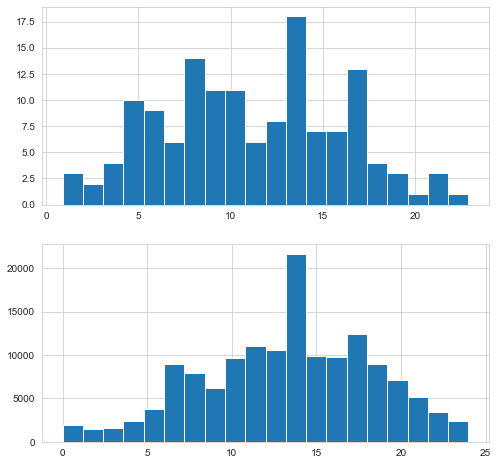

In [8]:
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.hist(Submissions.time/60, bins = 20, density = False)
plt.subplot(2,1,2)
plt.hist(Comments.time/60, bins = 20, density = False)


plt.show()

In [9]:
analyzer = SentimentIntensityAnalyzer()
cs = []
for row in range(len(Submissions)):
    if Submissions['body'].iloc[row] and Submissions['title'].iloc[row]:
        content = Submissions['title'].iloc[row] + ' ' + Submissions['body'].iloc[row]
    elif Submissions['title'].iloc[row]:
        content = Submissions['title'].iloc[row]
    elif Submissions['body'].iloc[row]:
        content = Submissions['body'].iloc[row]
    else:
        content = ''
    cs.append(analyzer.polarity_scores(content)['compound'])
Submissions['compound_score'] = cs

In [10]:
def num_early_comments(parent_id, wait_sec = 60*60):
    sub_time = Submissions.loc[parent_id,'time_created']
    return len(Comments[(Comments.parent_id_new == parent_id) & (Comments.time_created - sub_time < wait_sec)])

In [11]:
count = []

for row in range(len(Submissions)):
    count.append(num_early_comments(Submissions['id'].iloc[row], wait_sec = 30*60))
Submissions['num_early_comments'] = count

## 3. Export data

In [14]:
features = ['title_len','body_len','upvote_ratio','time','compound_score','num_early_comments']
popularity = ['num_comments','num_top_comments','score']

In [15]:
Submissions[features+popularity].to_csv('train_test_data_v2.csv')